Transfer Learning (InceptionResNetV2)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime

In [7]:
# Parameters
size = 94
batch_size = 16
train_dir = r'C:\Users\User\FYP final\Eye dataset 01'
initial_epochs = 20
fine_tune_epochs = 10
fine_tune_at = 100

In [8]:
# Data Generators with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(size, size),
    subset="training",
    shuffle=True,
    class_mode='binary',
    color_mode='rgb'
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(size, size),
    subset='validation',
    shuffle=True,
    class_mode='binary',
    color_mode='rgb'
)


Found 79376 images belonging to 2 classes.
Found 19843 images belonging to 2 classes.


In [9]:
# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [4]:
# Transfer Learning with InceptionResNetV2
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(size, size, 3),
                                                     include_top=False,
                                                     weights='imagenet')
# Freeze the base model
base_model.trainable = False

# Add custom layers to the base model
inputs = tf.keras.Input(shape=(size, size, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer_adam, loss='binary_crossentropy', metrics=['accuracy'])

def train_model(model, train_generator, valid_generator, log_dir, initial_epochs, fine_tune_epochs, fine_tune_at):
    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    #EarlyStopping and ReduceLROnPlateau callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    model_check = tf.keras.callbacks.ModelCheckpoint('transferlearning_model.keras', monitor='val_loss', save_best_only=True)

    callbacks = [early_stop, reduce_lr, model_check, tensorboard_callback]

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=initial_epochs,
        callbacks=callbacks,
        verbose=1
    )

    # Unfreeze layers of the base model for fine-tuning
    base_model.trainable = True

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompile the model (after changing layer trainability)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Fine-tune the model
    history_fine = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=initial_epochs + fine_tune_epochs,
        initial_epoch=initial_epochs,  
        callbacks=callbacks,
        verbose=1
    )

    return history, history_fine

history, history_fine = train_model(model, train_generator, valid_generator, log_dir, initial_epochs, fine_tune_epochs, fine_tune_at)




Epoch 1/20


d:\ananconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4961/4961 ━━━━━━━━━━━━━━━━━━━━ 807s 158ms/step - accuracy: 0.8583 - loss: 0.3287 - val_accuracy: 0.9709 - val_loss: 0.1074 - learning_rate: 1.0000e-04
Epoch 2/20
4961/4961 ━━━━━━━━━━━━━━━━━━━━ 720s 145ms/step - accuracy: 0.9343 - loss: 0.1779 - val_accuracy: 0.9780 - val_loss: 0.0800 - learning_rate: 1.0000e-04
Epoch 3/20
4961/4961 ━━━━━━━━━━━━━━━━━━━━ 719s 145ms/step - accuracy: 0.9441 - loss: 0.1493 - val_accuracy: 0.9805 - val_loss: 0.0717 - learning_rate: 1.0000e-04
Epoch 4/20
4961/4961 ━━━━━━━━━━━━━━━━━━━━ 722s 146ms/step - accuracy: 0.9485 - loss: 0.1407 - val_accuracy: 0.9861 - val_loss: 0.0590 - learning_rate: 1.0000e-04
Epoch 5/20
4961/4961 ━━━━━━━━━━━━━━━━━━━━ 722s 146ms/step - accuracy: 0.9491 - loss: 0.1342 - val_accuracy: 0.9839 - val_loss: 0.0596 - learning_rate: 1.0000e-04
Epoch 6/20
4961/4961 ━━━━━━━━━━━━━━━━━━━━ 727s 146ms/step - accuracy: 0.9525 - loss: 0.1293 - val_accuracy: 0.9839 - val_loss: 0.0597 - learning_rate: 1.0000e-04
Epoch 7/20
4961/4961 ━━━━━━━━━━━━━━━━━━

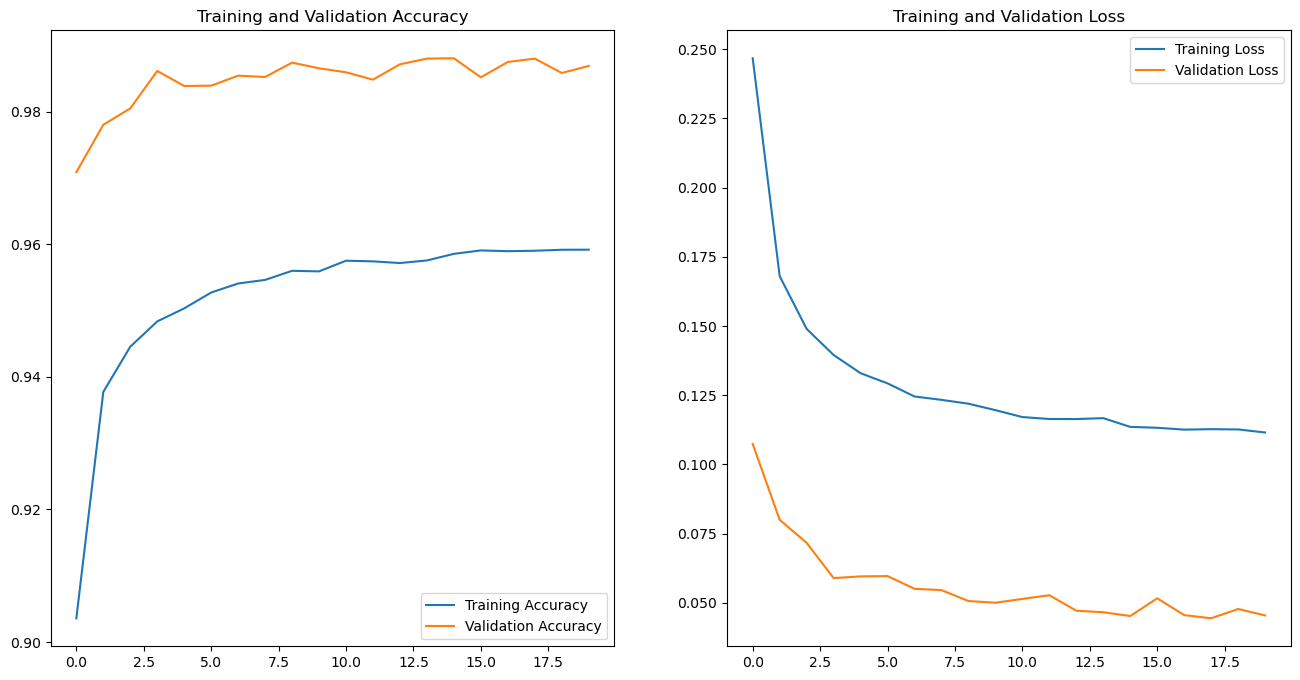

In [5]:
# Display training progress
def display_training_progress(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

display_training_progress(history)

Found 4846 images belonging to 2 classes.
303/303 ━━━━━━━━━━━━━━━━━━━━ 64s 176ms/step - accuracy: 0.8918 - loss: 0.5409
Test Loss: 0.3825603425502777
Test Accuracy: 0.9193149209022522
303/303 ━━━━━━━━━━━━━━━━━━━━ 57s 171ms/step
Confusion Matrix:
[[2093  291]
 [ 100 2362]]


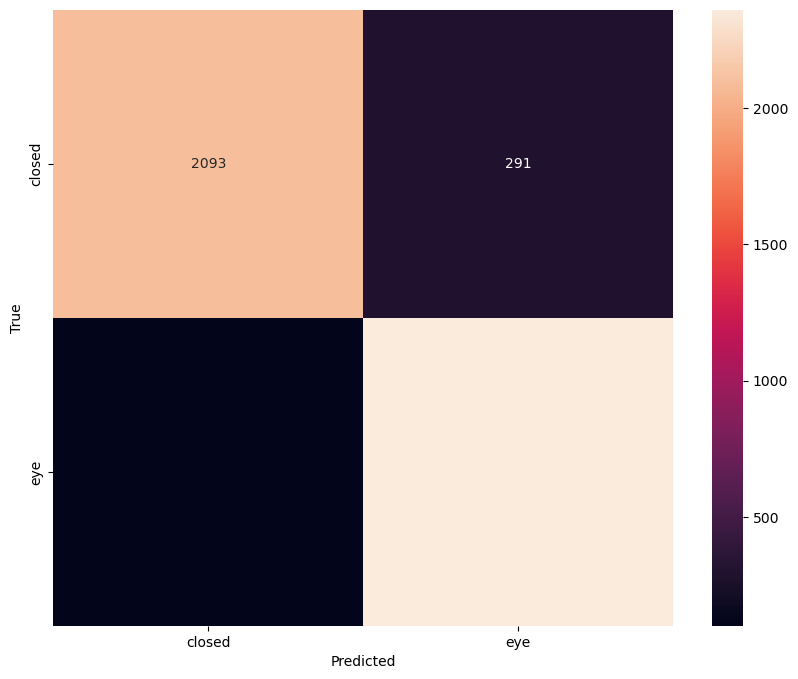

Test Precision: 0.8903128504753113
Test Recall: 0.9593825936317444


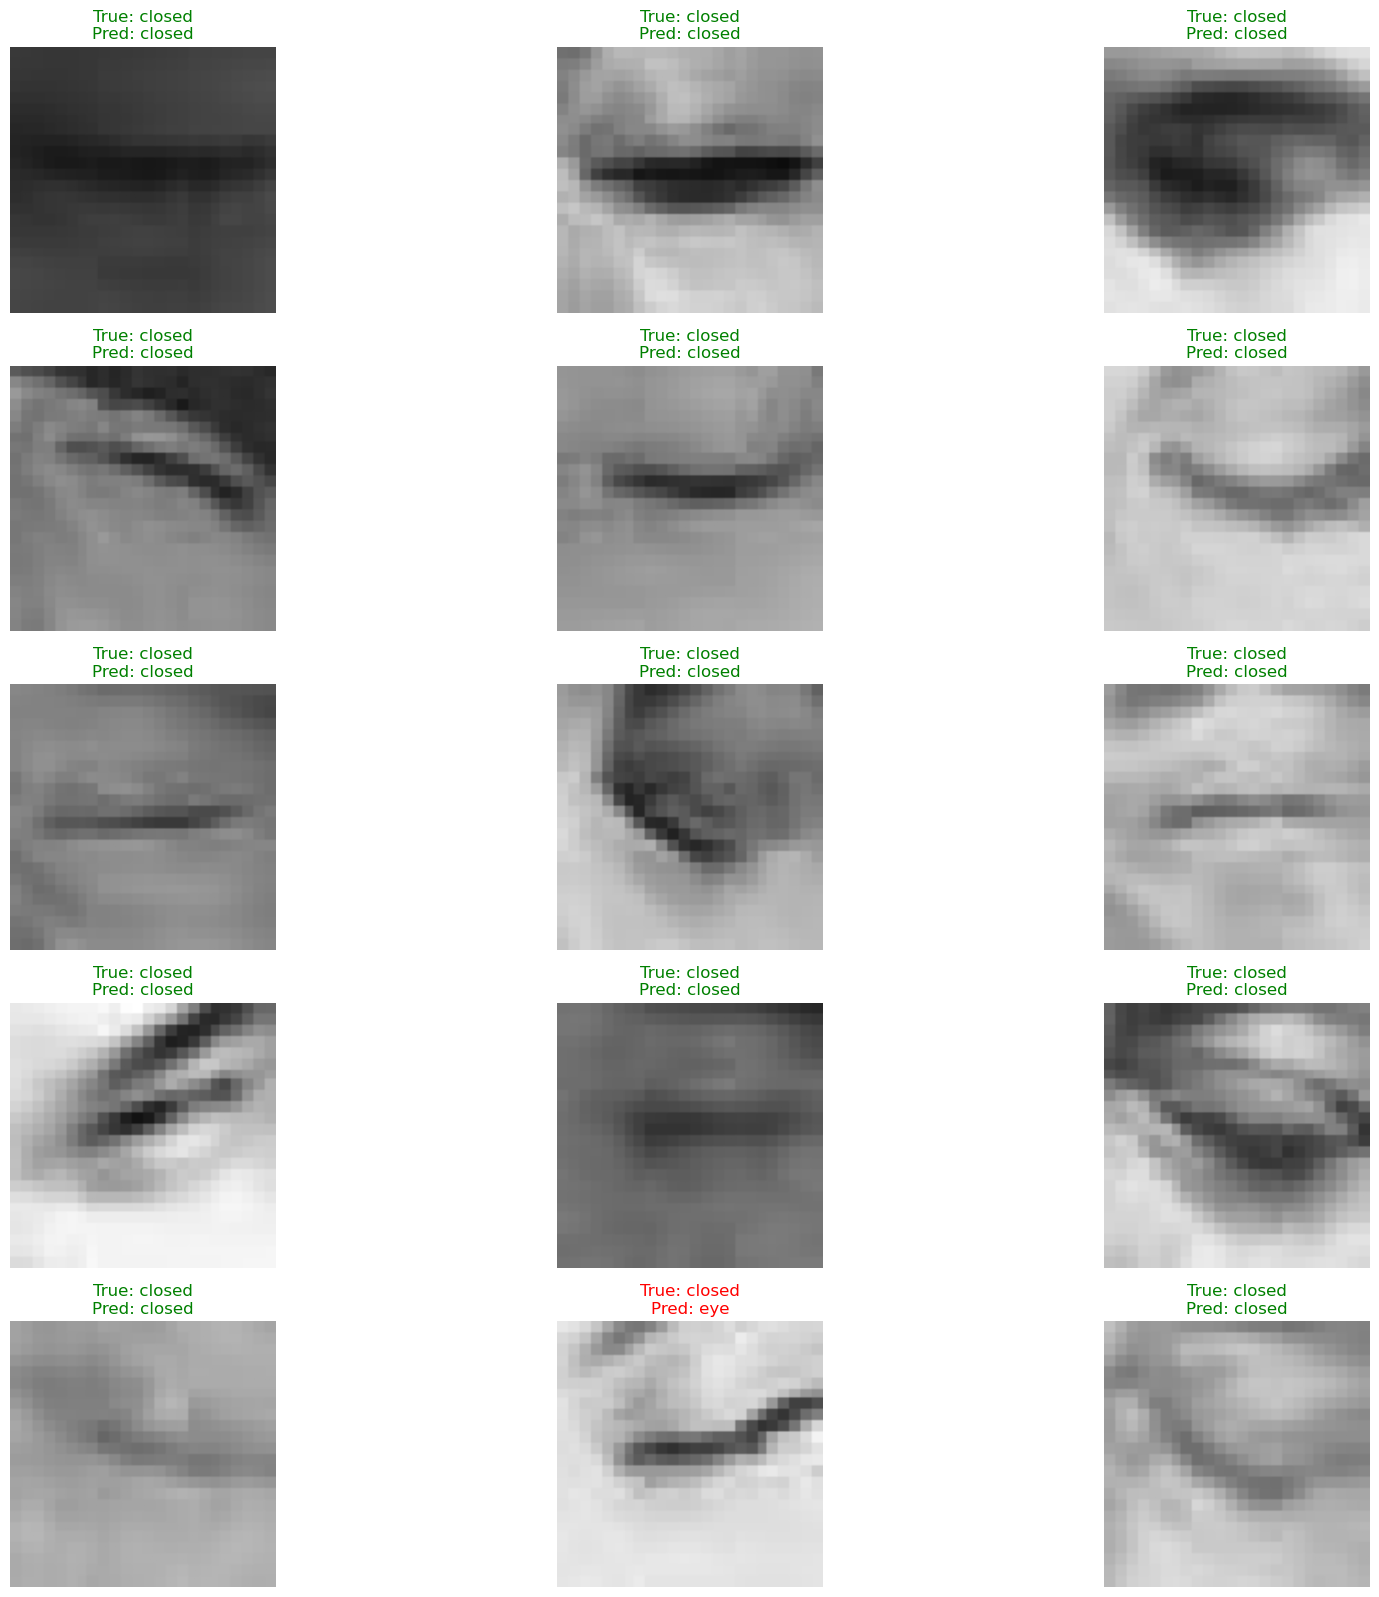

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Parameters
test_dir = r'C:\Users\User\fyp\test_dataset'  
size = 94
batch_size = 16

# Data Generator for testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='binary',  
    shuffle=False
)

# Load the trained model
model = tf.keras.models.load_model('transferlearning_model.keras')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").reshape(-1)  

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
confusion_mtx = tf.math.confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(confusion_mtx.numpy())

# Display confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
precision.update_state(true_classes, predicted_classes)
recall.update_state(true_classes, predicted_classes)
print(f"Test Precision: {precision.result().numpy()}")
print(f"Test Recall: {recall.result().numpy()}")

# Display a few test images with predictions
def display_test_images_with_predictions(generator, predictions, true_classes, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(15):
        plt.subplot(5, 3, i + 1)
        img, label = generator[i]
        img = img[0]
        plt.imshow(img)
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predictions[i]]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
    plt.show()

# Display a few test images with their predictions
display_test_images_with_predictions(test_generator, predicted_classes, true_classes, class_labels)
